# analysis
Make sky maps and calculate significance

Author: Nik Korzoun

# Imports

In [73]:
# imports
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.patches import Circle
from matplotlib.patches import Rectangle
import numpy as np
import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.coordinates import SkyCoord
import seaborn as sns

# Read Data
1 corresponds to gamma-rays and 2 corresponds to cosmic-rays

e.g. df1 is the dataframe with gamma-ray data and df2 is the dataframe with cosmic-ray data

## Data files

In [74]:
# read data
# files = [
#     "../data/PH_Markarian_onskyph11.5pe__20240317_101114_130.pcapng.root.csv"
# ]

import glob
# files=glob.glob("../October2024/d20241101/ph/cleaned/*.csv")
# files=glob.glob("../October2024/d20241101/ph/cleaned/*.corrected.csv")

# files=glob.glob("../March2024/*.csv")

files1 = glob.glob("../October2024/d20241101/ph/cleaned/*.csv")
files2 = glob.glob("../October2024/d20241031/ph/cleaned/*.csv")
files3 = glob.glob("../October2024/d20241030/ph/cleaned/*.csv")


files=files1+files2+files3
files=[f for f in files if "Crab" in f]
# files=[f for f in files if "Boomerang" in f]
files=[f for f in files if "corrected" in f]
# files=[f for f in files if "no_shift" not in f]

# files = glob.glob("../March2024/*.root.csv")
#files.remove("../data/arraytest.root.csv")
files = sorted(files)

# len(files)

# files = files[:14]

# for f in files:
#     print(f)

buffer=0
list=[]
for f in files:
    temp = pd.read_csv(f)
    temp["File"]=f[36:-16]
    temp["In-file-Index"]=temp["Event"]
    temp["Event"]=temp["Event"]+buffer
    buffer+=len(temp)
    list.append(temp)

df = pd.concat(list, ignore_index=True)
# df = pd.concat((pd.read_csv(f) for f in files), ignore_index=True)

In [75]:
# #test on sims
# df1 = pd.read_csv("../../corsika/data/lick2024/MRK421-sim-gamma/data/_merged.10xSig.reconstructed.csv")
# df2 = pd.read_csv("../../corsika/data/lick2024/MRK421-sim-proton/data/_merged.10xSig.reconstructed.csv")
# df2.Event=df2.Event+len(df1.Event)
# combined=pd.concat([df1,df2])
# df=combined.sample(frac=0.7)

# # so as not to break anything
# df['In-file-Index']=df.index
# df['File']=df.index


## Cleaning data

In [76]:
# remove nans and duplicates
array=df.dropna(subset=["Length", "Width","Miss","Distance","Azwidth","Alpha"])
array=array.drop_duplicates(subset=array.drop(["Telescope","Event", "In-file-Index"], axis=1))
array=array[array["Width"]>0]

# array=array[array["StdX"]>1]
# array=array[array["StdY"]>1]
# array=array[array["MeanX"]<1]
# array=array[array["MeanY"]<1]
# array=array[array["MeanX"]>-1]
# array=array[array["MeanY"]>-1]
# array=array[array["Size"]>1e3]

# array=array[array["Length"]>4*array["Width"]]
# array=array[array["Length"]>4]
# array=array[array["Size"]>1e3]
# array=array[array["Distance"]<3.5]
# array=array[array["Width"]<0.3]

# cut by number of telescopes
minTel=2
array = array.groupby('Event', group_keys=False).filter(lambda x: len(x) > (minTel-1))

array.head()
# with pd.option_context('display.max_rows', None):
#   display(array)

# array.head(15)

,Event,Telescope,Timestamp,MeanX,StdX,MeanY,StdY,Phi,Size,Length,Width,Miss,Distance,Azwidth,Alpha,File,In-file-Index
111,38,1,1.730275e+09,0.598356,0.339182,-3.088575,0.347429,49.265805,2541.0,0.370081,0.314310,2.468854,3.146002,0.349710,51.698405,Pause_onsky_Crabph0pe_ima0pe__20241030_080321_...,38
112,38,2,1.730275e+09,1.620975,0.278871,-2.416285,0.332465,303.251894,3720.0,0.367751,0.230350,0.030670,2.909638,0.230370,0.603959,Pause_onsky_Crabph0pe_ima0pe__20241030_080321_...,38
423,142,1,1.730275e+09,2.703920,0.372107,0.298748,0.494635,61.171907,4847.0,0.539274,0.303827,2.224773,2.720373,0.474423,54.867048,Pause_onsky_Crabph0pe_ima0pe__20241030_080321_...,142
424,142,2,1.730275e+09,-1.355196,0.324375,-1.259943,0.532061,89.064201,13440.0,0.532105,0.324302,1.334438,1.850409,0.444663,46.150191,Pause_onsky_Crabph0pe_ima0pe__20241030_080321_...,142
570,191,1,1.730276e+09,4.353911,0.264558,-0.711562,0.182645,354.720776,785.0,0.265153,0.181780,0.307943,4.411674,0.182278,4.002605,Pause_onsky_Crabph0pe_ima0pe__20241030_080321_...,191


In [77]:
array.describe()

,Event,Telescope,Timestamp,MeanX,StdX,MeanY,StdY,Phi,Size,Length,Width,Miss,Distance,Azwidth,Alpha,In-file-Index
count,3399.000000,3399.000000,3.399000e+03,3399.000000,3399.000000,3399.000000,3399.000000,3399.000000,3.399000e+03,3399.000000,3399.000000,3399.000000,3399.000000,3399.000000,3399.000000,3399.000000
mean,200974.467490,2.092674,1.730367e+09,-0.050766,0.390527,-0.360149,0.389985,184.920934,8.340903e+03,0.494141,0.266858,2.237081,3.528258,0.392712,43.747521,991.566343
std,125971.531007,0.816222,8.278863e+04,2.689290,0.261826,2.648487,0.242691,137.709051,3.422532e+04,0.306838,0.150031,1.489192,1.388101,0.277433,25.577601,1483.146782
min,38.000000,1.000000,1.730275e+09,-6.681576,0.108909,-4.757702,0.101100,0.014952,1.980000e+02,0.150730,0.059509,0.001257,0.130817,0.095682,0.027757,1.000000
25%,58165.000000,1.000000,1.730284e+09,-2.270194,0.245994,-2.649802,0.249497,45.970526,1.219500e+03,0.317517,0.188776,0.959287,2.506406,0.246435,21.994768,279.000000
50%,276249.000000,2.000000,1.730360e+09,-0.110073,0.328317,-0.509207,0.337189,272.312807,2.581000e+03,0.424050,0.241309,2.053038,3.662793,0.328561,43.087781,620.000000
75%,312997.000000,3.000000,1.730452e+09,2.180461,0.452434,1.816248,0.456526,315.366566,6.341500e+03,0.566532,0.308040,3.400568,4.581715,0.451195,65.726814,1046.000000
max,355177.000000,3.000000,1.730463e+09,5.174117,3.056916,4.752165,3.200679,359.919601,1.426572e+06,3.673075,1.549559,7.105091,7.619279,3.411775,89.999522,15091.000000


# Arrival Directions

In [78]:
array.head()

,Event,Telescope,Timestamp,MeanX,StdX,MeanY,StdY,Phi,Size,Length,Width,Miss,Distance,Azwidth,Alpha,File,In-file-Index
111,38,1,1.730275e+09,0.598356,0.339182,-3.088575,0.347429,49.265805,2541.0,0.370081,0.314310,2.468854,3.146002,0.349710,51.698405,Pause_onsky_Crabph0pe_ima0pe__20241030_080321_...,38
112,38,2,1.730275e+09,1.620975,0.278871,-2.416285,0.332465,303.251894,3720.0,0.367751,0.230350,0.030670,2.909638,0.230370,0.603959,Pause_onsky_Crabph0pe_ima0pe__20241030_080321_...,38
423,142,1,1.730275e+09,2.703920,0.372107,0.298748,0.494635,61.171907,4847.0,0.539274,0.303827,2.224773,2.720373,0.474423,54.867048,Pause_onsky_Crabph0pe_ima0pe__20241030_080321_...,142
424,142,2,1.730275e+09,-1.355196,0.324375,-1.259943,0.532061,89.064201,13440.0,0.532105,0.324302,1.334438,1.850409,0.444663,46.150191,Pause_onsky_Crabph0pe_ima0pe__20241030_080321_...,142
570,191,1,1.730276e+09,4.353911,0.264558,-0.711562,0.182645,354.720776,785.0,0.265153,0.181780,0.307943,4.411674,0.182278,4.002605,Pause_onsky_Crabph0pe_ima0pe__20241030_080321_...,191


In [79]:
# array=array.drop(columns=["Telescope","Event", "In-file-Index"])
# array.duplicated().value_counts()
array=array.drop_duplicates(subset=array.drop(["Telescope","Event"], axis=1))

In [80]:
array.describe()

,Event,Telescope,Timestamp,MeanX,StdX,MeanY,StdY,Phi,Size,Length,Width,Miss,Distance,Azwidth,Alpha,In-file-Index
count,3399.000000,3399.000000,3.399000e+03,3399.000000,3399.000000,3399.000000,3399.000000,3399.000000,3.399000e+03,3399.000000,3399.000000,3399.000000,3399.000000,3399.000000,3399.000000,3399.000000
mean,200974.467490,2.092674,1.730367e+09,-0.050766,0.390527,-0.360149,0.389985,184.920934,8.340903e+03,0.494141,0.266858,2.237081,3.528258,0.392712,43.747521,991.566343
std,125971.531007,0.816222,8.278863e+04,2.689290,0.261826,2.648487,0.242691,137.709051,3.422532e+04,0.306838,0.150031,1.489192,1.388101,0.277433,25.577601,1483.146782
min,38.000000,1.000000,1.730275e+09,-6.681576,0.108909,-4.757702,0.101100,0.014952,1.980000e+02,0.150730,0.059509,0.001257,0.130817,0.095682,0.027757,1.000000
25%,58165.000000,1.000000,1.730284e+09,-2.270194,0.245994,-2.649802,0.249497,45.970526,1.219500e+03,0.317517,0.188776,0.959287,2.506406,0.246435,21.994768,279.000000
50%,276249.000000,2.000000,1.730360e+09,-0.110073,0.328317,-0.509207,0.337189,272.312807,2.581000e+03,0.424050,0.241309,2.053038,3.662793,0.328561,43.087781,620.000000
75%,312997.000000,3.000000,1.730452e+09,2.180461,0.452434,1.816248,0.456526,315.366566,6.341500e+03,0.566532,0.308040,3.400568,4.581715,0.451195,65.726814,1046.000000
max,355177.000000,3.000000,1.730463e+09,5.174117,3.056916,4.752165,3.200679,359.919601,1.426572e+06,3.673075,1.549559,7.105091,7.619279,3.411775,89.999522,15091.000000


In [81]:
array.Event.nunique()

1567

# Arrival Directions

In [82]:
event_list = array.drop_duplicates(subset='Event').Event.to_numpy()

Shower_Xoffset = []
Shower_Yoffset = []
file = []
in_file_index = []
for e in event_list:

    event=array[array.Event == e]
    NTel = len(event)
    
    # check that there are enough images
    if NTel < 2:
        continue # skips to next iteration in for loop
        
    
    m = []
    x = []
    y = []
    s = []
    l = []

    # get relevant image parameters
    for t in range(NTel):
        tel=event.iloc[t]

        s.append(tel.Size)
        x.append(tel.MeanX)
        y.append(tel.MeanY)
        phi_rad = tel.Phi * np.pi/180
        m.append(np.tan(phi_rad))
        if(tel.Length > 0):
            l.append(tel.Width/tel.Length)
        else:
            l.append(1)

    # don't do anything if angle between image axis is too small (for 2 images only)
    fiangdiff = 0
    if NTel == 2:
        fiangdiff = -1*np.abs(np.arctan(m[0]) - np.arctan(m[1])) * 180/np.pi

    # direction reconstruction
    itotweight = 0.
    iweight = 1.
    ixs = 0.
    iys = 0.
    iangdiff = 0.
    b1 = 0.
    b2 = 0.
    v_xs = []
    v_ys = []
    fmean_iangdiff = 0.
    fmean_iangdiffN = 0.

    for i in range(NTel):
        for j in range(NTel):
            if i >= j:
                continue

            # check minimum angle between image lines; ignore if too small
            iangdiff = np.abs( np.arctan( m[j] ) - np.arctan( m[i] ) )
            if( iangdiff < 0 or np.abs(np.pi - iangdiff ) < 0 ):
                continue
            
            # mean angle between images
            if( iangdiff < np.pi/2 ):
                fmean_iangdiff += iangdiff * 180/np.pi
            else:
                fmean_iangdiff += ( 180 - (iangdiff * 180/np.pi))
            fmean_iangdiffN += 1
            
            # weight is sin of angle between image lines
            iangdiff = np.abs( np.sin( np.abs( np.arctan( m[j] ) - np.arctan( m[i] ) ) ) )
            
            b1 = y[i] - m[i] * x[i]
            b2 = y[j] - m[j] * x[j]
            
            # line intersection
            if( m[i] != m[j] ):
                xs = ( b2 - b1 )  / ( m[i] - m[j] )
            else:
                xs = 0.
        
            ys = m[i] * xs + b1

            iweight  = 1. / ( 1. / s[i] + 1. / s[j] ) # weight 1: size of images
            iweight *= ( 1. - l[i] ) * ( 1. - l[j] ) # weight 2: elongation of images (width/length)
            iweight *= iangdiff                      # weight 3: angular differences between the two image axis
            iweight *= iweight                       # use squared value

            ixs += xs * iweight
            iys += ys * iweight
            itotweight += iweight
            
            v_xs.append( xs )
            v_ys.append( ys )

    # average difference between image pairs
    if( fmean_iangdiffN > 0. ):
        fmean_iangdiff /= fmean_iangdiffN
    else:
        fmean_iangdiff = 0.

    if( NTel > 2 ):
        fiangdiff = fmean_iangdiff  
	
	# check validity of weight
    if( itotweight > 0. ):

        ixs /= itotweight
        iys /= itotweight
        Shower_Xoffset.append(ixs)
        Shower_Yoffset.append(iys)
        file.append(event.iloc[0].File)
        in_file_index.append(event["In-file-Index"].iloc[0])
	
    else:

        print("Image weights invalid")
        print(e)
        # Shower_Xoffset.append(np.nan)
        # Shower_Yoffset.append(np.nan)

In [83]:
directions=pd.DataFrame()
directions['File'] = file
directions['In-file-Index'] = in_file_index
directions['Xoffset'] = Shower_Xoffset
directions['Yoffset'] = Shower_Yoffset
directions.describe()

,In-file-Index,Xoffset,Yoffset
count,1567.000000,1567.000000,1567.000000
mean,991.434588,-1.486090,-1.278402
std,1501.080550,75.892035,49.087838
min,1.000000,-2805.492569,-1664.921452
25%,279.500000,-2.549845,-2.783542
50%,609.000000,-0.000358,-0.340107
75%,1038.500000,2.477795,2.048821
max,15091.000000,914.880255,748.786169


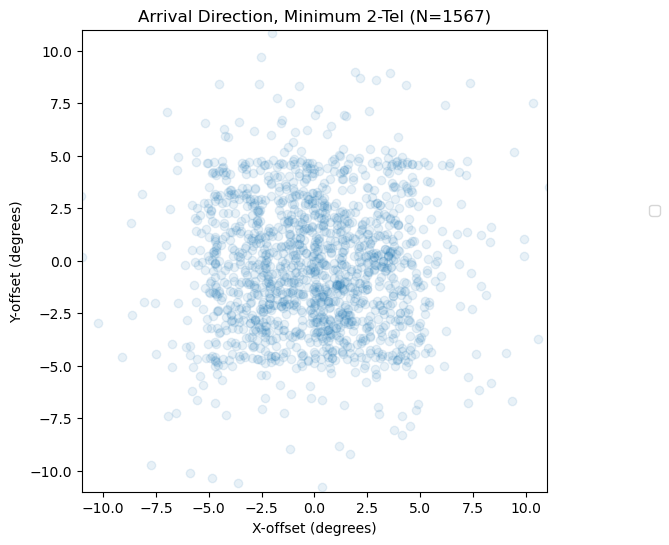

In [84]:
fig,axs = plt.subplots(figsize=(6,6))
plt.xlabel('X-offset (degrees)')
plt.ylabel('Y-offset (degrees)')
axs.set(xlim=[-11,11],ylim=[-11,11],title='Arrival Direction, Minimum {:.0f}-Tel (N={:.0f})'.format(minTel,len(event_list)))
axs.scatter(directions.Xoffset,directions.Yoffset,alpha=0.1)

handles, labels = axs.get_legend_handles_labels()
fig.legend(handles, labels,bbox_to_anchor=(1.1, 0.6));

### Convert to RA/DEC

In [85]:
# pointing
center=SkyCoord('05 44 32 +22 01 03', unit=(u.hourangle, u.deg))
# center=SkyCoord('11 04 19 +38 11 41', unit=(u.hourangle, u.deg))

# Create a WCS object with tangent projection
w = wcs.WCS(naxis=2)
w.wcs.crpix = [0,0]
w.wcs.crval = [center.ra.deg,center.dec.deg]
w.wcs.cdelt = [-1,1]
w.wcs.ctype = ["RA---TAN", "DEC--TAN"]

# Convert
directions['RA'],directions['DEC'] = w.wcs_pix2world(directions.Yoffset,directions.Xoffset,1)

In [86]:
w

WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN' 'DEC--TAN' 
CRVAL : 86.13333333333331 22.0175 
CRPIX : 0.0 0.0 
PC1_1 PC1_2  : 1.0 0.0 
PC2_1 PC2_2  : 0.0 1.0 
CDELT : -1.0 1.0 
NAXIS : 0  0

In [87]:
directions.describe()

,In-file-Index,Xoffset,Yoffset,RA,DEC
count,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000
mean,991.434588,-1.486090,-1.278402,86.689937,21.771026
std,1501.080550,75.892035,49.087838,9.867862,6.204865
min,1.000000,-2805.492569,-1664.921452,6.644093,-52.236350
25%,279.500000,-2.549845,-2.783542,83.909493,19.411475
50%,609.000000,-0.000358,-0.340107,86.500385,21.981069
75%,1038.500000,2.477795,2.048821,89.121224,24.419317
max,15091.000000,914.880255,748.786169,334.971450,79.639502


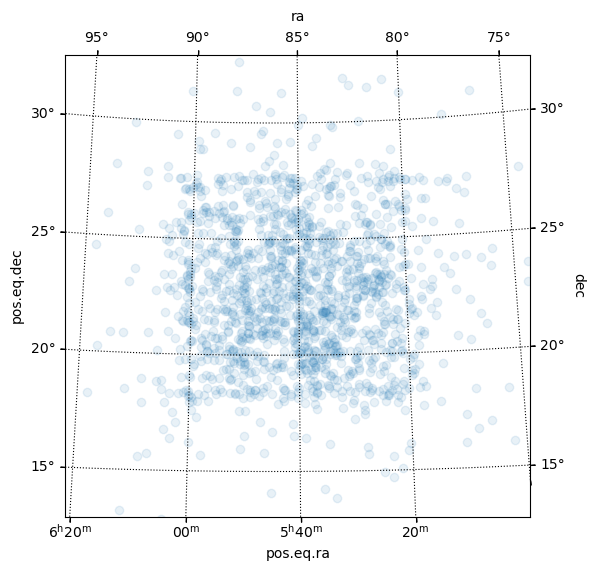

In [88]:

fig=plt.figure(figsize=(6,6))
ax = plt.subplot(projection=w)
ax.set_xlim(-10,10)
ax.set_ylim(-10,10)
ax.scatter(directions.Xoffset,directions.Yoffset,alpha=0.1)

overlay = ax.get_coords_overlay('icrs')
overlay.grid(color='black', ls='dotted')

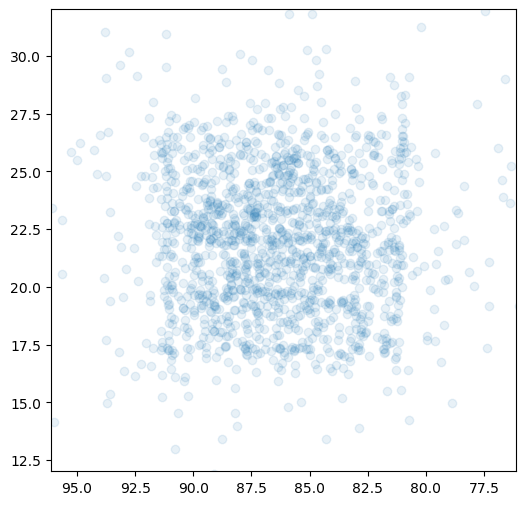

In [89]:
fig=plt.figure(figsize=(6,6))
ax = plt.subplot()
ax.set_xlim(center.ra.deg-10,center.ra.deg+10)
ax.set_ylim(center.dec.deg-10,center.dec.deg+10)
ax.scatter(directions.RA,directions.DEC,alpha=0.1)
plt.gca().invert_xaxis()


In [90]:
directions.describe()

,In-file-Index,Xoffset,Yoffset,RA,DEC
count,1567.000000,1567.000000,1567.000000,1567.000000,1567.000000
mean,991.434588,-1.486090,-1.278402,86.689937,21.771026
std,1501.080550,75.892035,49.087838,9.867862,6.204865
min,1.000000,-2805.492569,-1664.921452,6.644093,-52.236350
25%,279.500000,-2.549845,-2.783542,83.909493,19.411475
50%,609.000000,-0.000358,-0.340107,86.500385,21.981069
75%,1038.500000,2.477795,2.048821,89.121224,24.419317
max,15091.000000,914.880255,748.786169,334.971450,79.639502


# Test Position

In [91]:
Crab=SkyCoord('05 34 31.78 +22 01 02.6', unit=(u.hourangle, u.deg))
HAWC=SkyCoord('05 43 07.20 +23 24 00.0', unit=(u.hourangle, u.deg))
MRK421=SkyCoord('11 04 19 +38 11 41', unit=(u.hourangle, u.deg))

# testPosX=MRK421.ra.deg
# testPosY=MRK421.dec.deg

testPosX=Crab.ra.deg
testPosY=Crab.dec.deg

# testPosX=HAWC.ra.deg
# testPosY=HAWC.dec.deg


In [92]:
testPosX

83.63241666666664

In [93]:
testPosY

22.01738888888889

In [94]:
# directions.describe()

# Plot

In [95]:
binwidth=0.2
bins_RA = np.arange(center.ra.deg-5,center.ra.deg+5, binwidth)  
bins_DEC = np.arange(center.dec.deg-5,center.dec.deg+5, binwidth)

radius=0.32214

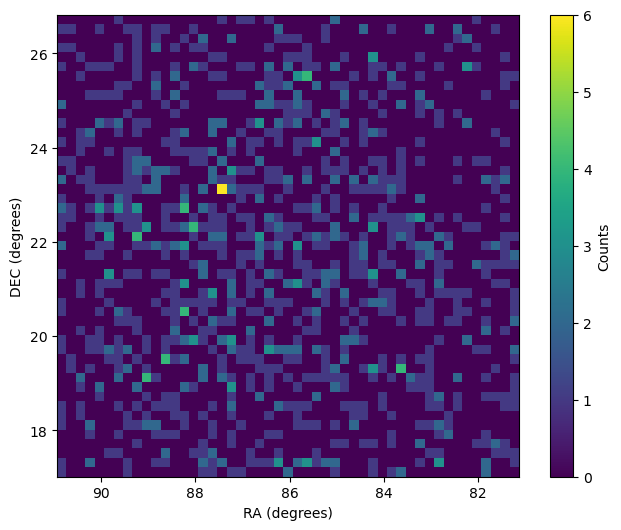

In [96]:
fig, ax = plt.subplots(figsize=(8, 6))

hist = ax.hist2d(directions.RA, directions.DEC, bins=[bins_RA, bins_DEC], cmap='viridis')

ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_xlabel('RA (degrees)')
ax.set_ylabel('DEC (degrees)')

cbar = fig.colorbar(hist[3], ax=ax, label='Counts')

plt.show()


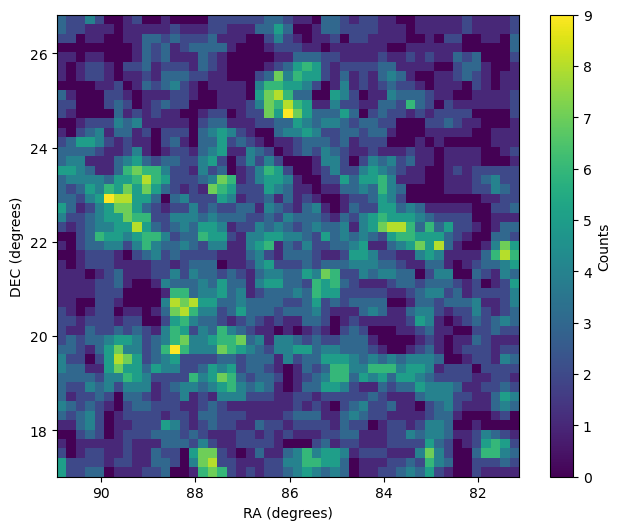

In [97]:
data=pd.DataFrame(columns=['testPosX','testPosY','Counts'])

for x in bins_RA:
    x=x+binwidth/2 #bin center
    for y in bins_DEC:
        y=y+binwidth/2 #bin center

        # reset
        map=directions.copy()
        tmp=array

        # calc distance with respect to test position
        mx,my=w.wcs_pix2world(tmp.MeanY,tmp.MeanX,1)
        tmp['Distance'] = np.hypot(mx-x,my-y)

        # create max distance parameter
        max = tmp.groupby(['Event'])['Distance'].transform('max') == tmp['Distance']
        max_distance= tmp.loc[max, ['Event', 'Distance']]
        map['MaxDistance']=max_distance.Distance.values

        # calc theta squared
        angle=np.hypot(map.RA-x,map.DEC-y)
        sqr=angle*angle
        map['ThetaSquare']=sqr.values

        # apply cuts
        map=map[map['MaxDistance'] < 2]
        map=map[map['ThetaSquare'] < radius**2]

        counts=len(map)
        data.loc[-1]=[x,y,counts]
        data.index = data.index + 1


fig, ax = plt.subplots(figsize=(8, 6))

hist = ax.hist2d(data.testPosX, data.testPosY, weights=data.Counts, bins=[bins_RA, bins_DEC], cmap='viridis')

ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_xlabel('RA (degrees)')
ax.set_ylabel('DEC (degrees)')

cbar = fig.colorbar(hist[3], ax=ax, label='Counts')

plt.show()
# plt.savefig('/home/nkorzoun/Downloads/counts.png',dpi=300)

In [98]:
data.describe()

,testPosX,testPosY,Counts
count,2500.000000,2500.000000,2500.000000
mean,86.133333,22.017500,2.277600
std,2.886751,2.886751,1.685727
min,81.233333,17.117500,0.000000
25%,83.633333,19.517500,1.000000
50%,86.133333,22.017500,2.000000
75%,88.633333,24.517500,3.000000
max,91.033333,26.917500,9.000000


## Define On/Off Regions

In [99]:
def make_off_regions(testPosX,testPosY):
    n_circ=0
    off_regions=[]
    skip=4
    for i in range(5,len(bins_RA)-1,skip):
        for j in range(5,len(bins_DEC)-1,skip):
            # Calculate the center of each bin
            center_x = (bins_RA[i] + bins_RA[i+1]) / 2
            center_y = (bins_DEC[j] + bins_DEC[j+1]) / 2
            
            buffer=1.4
            if (center_x<testPosX-buffer or center_x>testPosX+buffer or center_y<testPosY-buffer or center_y>testPosY+buffer ):
                n_circ=n_circ+1
                off_regions.append((center_x,center_y))

    return off_regions

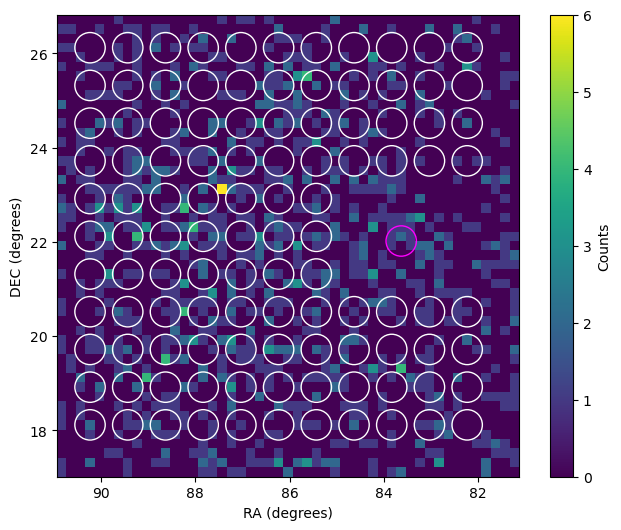

Number of off regions:  109


In [100]:
fig, ax = plt.subplots(figsize=(8, 6))

hist = ax.hist2d(directions.RA, directions.DEC, bins=[bins_RA, bins_DEC], cmap='viridis')

ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_xlabel('RA (degrees)')
ax.set_ylabel('DEC (degrees)')

cbar = fig.colorbar(hist[3], ax=ax, label='Counts')



on_region=(testPosX,testPosY)
off_regions=make_off_regions(*on_region)

for region in off_regions:
    circ = Circle(region, radius, facecolor='None', edgecolor='white', lw=1)
    ax.add_patch(circ)
ax.add_patch(Circle(on_region,radius,facecolor='None',edgecolor='magenta', lw=1))

plt.show()            
print('Number of off regions: ',len(off_regions))

In [101]:
# teston=(86,22)
# fig, ax = plt.subplots(figsize=(8, 6))

# hist = ax.hist2d(directions.RA, directions.DEC, bins=[bins_RA, bins_DEC], cmap='viridis')

# ax.invert_xaxis()
# ax.set_aspect('equal')
# ax.set_xlabel('RA (degrees)')
# ax.set_ylabel('DEC (degrees)')

# cbar = fig.colorbar(hist[3], ax=ax, label='Counts')
# for region in make_off_regions(*teston):
#     circ = Circle(region, radius, facecolor='None', edgecolor='white', lw=1)
#     ax.add_patch(circ)
# ax.add_patch(Circle(teston,radius,facecolor='None',edgecolor='magenta', lw=1))

Text(0, 0.5, 'DEC (degrees)')

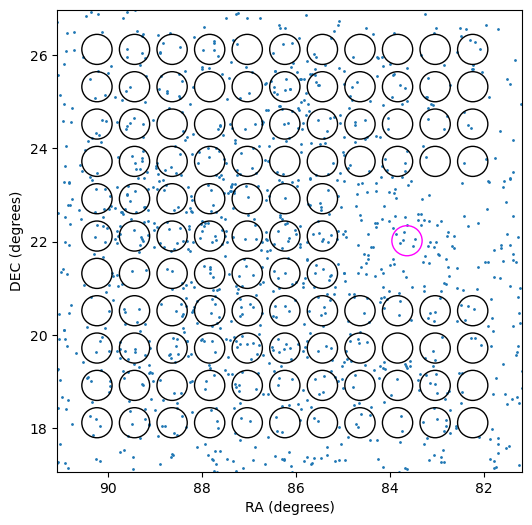

In [102]:
# scatter plot w/ on/off regions

fig=plt.figure(figsize=(6,6))
ax = plt.subplot()
ax.set_xlim(center.ra.deg-4.95,center.ra.deg+4.95)
ax.set_ylim(center.dec.deg-4.95,center.dec.deg+4.95)
ax.scatter(directions.RA,directions.DEC,alpha=1,s=1)
plt.gca().invert_xaxis()

off_regions=make_off_regions(*on_region)

for region in off_regions:
    circ = Circle(region, radius, facecolor='None', edgecolor='black', lw=1)
    ax.add_patch(circ)
ax.add_patch(Circle(on_region,radius,facecolor='None',edgecolor='magenta', lw=1))
plt.xlabel('RA (degrees)')
plt.ylabel('DEC (degrees)')

# plt.savefig('/home/nkorzoun/Downloads/OnOff.png',dpi=300)

# Significance

Li and Ma (9):
$S=\frac{N_{on}-\alpha N_{off}}{\sqrt{\alpha(N_{on}+N_{off})}}$

## $\alpha$

In [103]:
def calc_alpha(off_regions):
    area_B = np.pi*radius**2
    area_A = len(off_regions) * np.pi * radius**2
    alpha=area_B/area_A
    return alpha

In [104]:
calc_alpha(off_regions)

0.009174311926605505

## $N_{on}$

In [105]:
def calc_Non(on_region,array=array,directions=directions):

    on=directions
    tmp=array

    center_x,center_y=on_region

    # distance
    mx,my=w.wcs_pix2world(tmp.MeanY,tmp.MeanX,1)
    tmp['Distance'] = np.hypot(mx-center_x,my-center_y)
    max = tmp.groupby(['Event'])['Distance'].transform('max') == tmp['Distance']
    max_distance= tmp.loc[max, ['Event', 'Distance']]
    on['MaxDistance']=max_distance.Distance.values

    # theta square
    angle=np.hypot(on.RA-center_x,on.DEC-center_y)
    sqr=angle*angle
    on['ThetaSquare']=sqr.values

    # apply cuts
    on=on[on['MaxDistance'] < 2]
    on=on[on['ThetaSquare'] < 0.32214**2]

    return on

In [106]:
on=calc_Non(on_region)

In [107]:
len(on)

5

In [108]:
on.describe()

,In-file-Index,Xoffset,Yoffset,RA,DEC,MaxDistance,ThetaSquare
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000
mean,1247.200000,0.074349,2.304770,83.647591,22.072997,1.705611,0.036450
std,1865.491678,0.116829,0.154878,0.165580,0.118291,0.306549,0.024745
min,26.000000,-0.086366,2.101949,83.451658,21.910406,1.287473,0.007350
25%,328.000000,0.033948,2.241291,83.514968,22.033712,1.470965,0.025240
50%,494.000000,0.051499,2.263018,83.690078,22.047148,1.880223,0.033559
75%,846.000000,0.158652,2.430578,83.716579,22.160453,1.920415,0.041692
max,4542.000000,0.214010,2.487011,83.864673,22.213265,1.968977,0.074410


## $N_{off}$

In [109]:
def calc_Noff(off_regions,array=array,directions=directions):
    off = directions[0:0]

    for (center_x,center_y) in off_regions:
        # reset
        map=directions
        tmp=array

        # calc distance with respect to test position
        mx,my=w.wcs_pix2world(tmp.MeanY,tmp.MeanX,1)
        tmp['Distance'] = np.hypot(mx-center_x,my-center_y)

        # create max distance parameter
        max = tmp.groupby(['Event'])['Distance'].transform('max') == tmp['Distance']
        max_distance= tmp.loc[max, ['Event', 'Distance']]
        map['MaxDistance']=max_distance.Distance.values

        # calc theta squared
        angle=np.hypot(map.RA-center_x,map.DEC-center_y)
        sqr=angle*angle
        map['ThetaSquare']=sqr.values

        # apply cuts
        map=map[map['MaxDistance'] < 2]
        map=map[map['ThetaSquare'] < radius**2]

        off=pd.concat([off,map])

    return off

In [110]:
off=calc_Noff(off_regions)

In [111]:
len(off)

248

In [112]:
off.describe()

,In-file-Index,Xoffset,Yoffset,RA,DEC,MaxDistance,ThetaSquare
count,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000,248.000000
mean,933.560484,-0.437207,-0.704595,86.891145,21.564469,1.288106,0.049030
std,1161.235010,2.420309,2.076706,2.225937,2.417980,0.370842,0.030243
min,12.000000,-4.156044,-4.086024,82.065346,17.854179,0.225175,0.000144
25%,307.500000,-2.388760,-2.334968,85.410965,19.621074,1.064392,0.022699
50%,631.500000,-0.722457,-0.978951,87.190010,21.293973,1.277391,0.048634
75%,980.750000,1.669092,0.679227,88.638571,23.679129,1.561438,0.073457
max,6353.000000,4.251198,3.835821,90.444280,26.251866,1.988957,0.103411


## significance

In [ ]:
# def significance(on,off,alpha):
#     # eq9=(on - alpha*off) / np.sqrt(alpha*(on+off))

#     log1 = on * np.log(((1 + alpha) / alpha) * (on / (on + off))) if (on != 0) else 0
#     log2 = off * np.log((1 + alpha) * (off / (on + off))) if (off != 0) else 0
#     eq17 = np.sqrt(2 * (log1 + log2))

#     # return eq9
#     return eq17

# lifted from Eventdisplay VStatistics.h
def significance(Non,Noff,alpha):

    if( alpha == 0. ):
        Sig17 = 0.0
        return Sig17
    
    alphasq = alpha * alpha
    oneplusalpha = 1.0 + alpha
    oneplusalphaoveralpha = oneplusalpha / alpha

    Nsig = Non - alpha * Noff
    Ntot = Non + Noff

    # Sig5
    if( Non + alphasq * Noff > 0. ):
        Sig5 = Nsig / np.sqrt( Non + alphasq* Noff )
    else:
        Sig5 = 0.
    
    # Sig9
    if( alpha * Ntot > 0. ):
        Sig9 = Nsig / np.sqrt( alpha* Ntot )
    else:
        Sig9 = 0.
    
    # Sig17
    if( Ntot == 0. ):
        Sig17 = 0.
    elif( Non == 0 and Noff != 0. ):
        Sig17 = np.sqrt( 2.*( Noff* np.log( oneplusalpha * ( Noff / Ntot ) ) ) )
    elif( Non != 0 and Noff == 0. ):
        Sig17 = np.sqrt( 2.*( Non* np.log( oneplusalphaoveralpha * ( Non / Ntot ) ) ) )
    else:
        Sig17 = 2.*( Non* np.log( oneplusalphaoveralpha * ( Non / Ntot ) ) + Noff* np.log( oneplusalpha * ( Noff / Ntot ) ) )
        # value in brackets can be a small negative number
        if( np.abs( Sig17 ) < 1.e-15 ):
            Sig17 = 0.
        else:
            Sig17 = np.sqrt( Sig17 )
            
    
    if( Nsig < 0 ):
        Sig17 = -Sig17
    
    # return Sig5
    # return Sig9
    return Sig17

In [114]:
# scale_factor=4.6
# rate=1.39
# # rate = 1.43

# N_on=scale_factor*5*rate
# N_off=scale_factor*534

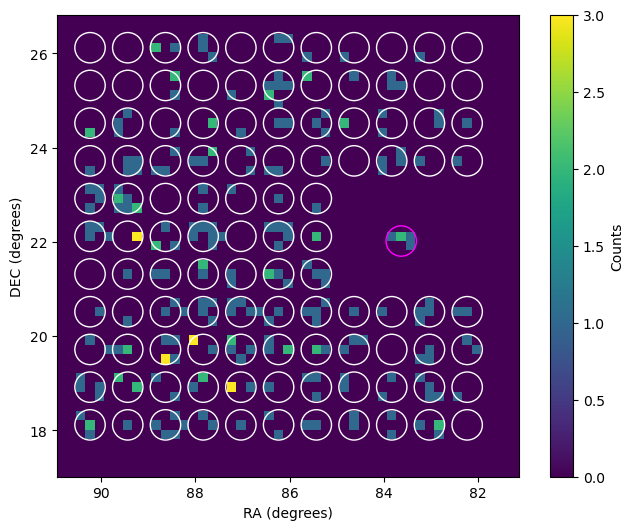

In [115]:
fig, ax = plt.subplots(figsize=(8, 6))
onoff=pd.concat([on,off])

hist = ax.hist2d(onoff.RA, onoff.DEC, bins=[bins_RA, bins_DEC], cmap='viridis')

ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_xlabel('RA (degrees)')
ax.set_ylabel('DEC (degrees)')

cbar = fig.colorbar(hist[3], ax=ax, label='Counts')

circ1 = Circle(on_region, radius, facecolor='None', edgecolor='magenta', lw=1)
ax.add_patch(circ1)

for region in off_regions:
    circ = Circle((region[0],region[1]), radius, facecolor='None', edgecolor='white', lw=1)
    ax.add_patch(circ)

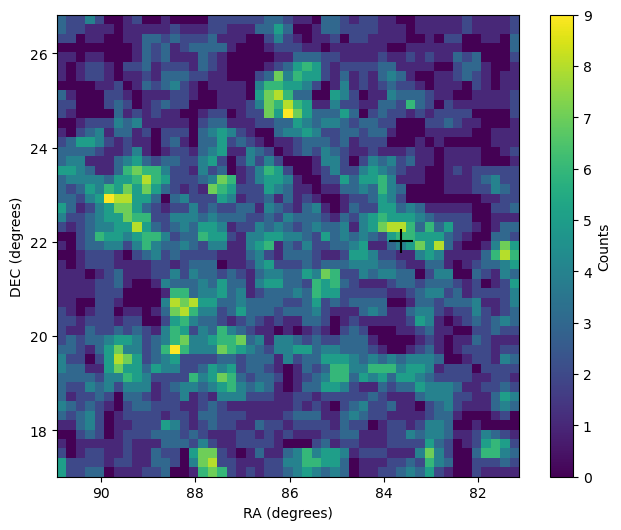

In [116]:
fig, ax = plt.subplots(figsize=(8, 6))

hist = ax.hist2d(data.testPosX, data.testPosY, weights=data.Counts, bins=[bins_RA, bins_DEC], cmap='viridis')

ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_xlabel('RA (degrees)')
ax.set_ylabel('DEC (degrees)')

cbar = fig.colorbar(hist[3], ax=ax, label='Counts')

# circ1 = Circle(on_region, radius, facecolor='None', edgecolor='magenta', lw=1)
# ax.add_patch(circ1)
ax.scatter(*on_region,marker='+',color='k',s=300)

In [117]:
# # assuming same background
# sig=pd.DataFrame(columns=['testPosX','testPosY','significance'])

# for x in np.arange(-5,5,0.2):
#     x=x+0.1 #bin center
#     for y in np.arange(-5,5,0.2):
#         y=y+0.1 #bin

#         # reset
#         on=directions
#         tmp=array

#         # calc distance with respect to test position
#         tmp['Distance'] = np.hypot(tmp.MeanX-x,tmp.MeanY-y)

#         # create max distance parameter
#         max = tmp.groupby(['Event'])['Distance'].transform('max') == tmp['Distance']
#         max_distance= tmp.loc[max, ['Event', 'Distance']]
#         on['MaxDistance']=max_distance.Distance.values

#         # calc theta squared
#         angle=np.hypot(on.Xoffset-x,on.Yoffset-y)
#         sqr=angle*angle
#         on['ThetaSquare']=sqr.values

#         # apply cuts
#         on=on[on['MaxDistance'] < 2]
#         on=on[on['ThetaSquare'] < 0.32214**2]

#         # calc significance
#         N_on = len(on)

#         significance=(N_on - alpha*N_off) / np.sqrt(alpha*(N_on+N_off))
#         sig.loc[-1]=[x,y,significance]
#         sig.index = sig.index + 1

# fig, ax = plt.subplots()
# sns.histplot(data=sig,x='testPosX',y='testPosY',weights='significance',binwidth=0.2,binrange=(-5,5),cbar=True,thresh=None,ax=ax,cmap='viridis',cbar_kws={'label': 'Significance'})
# circ1 = Circle(on_region, radius, facecolor='None', edgecolor='magenta', lw=1)
# # ax.add_patch(circ1)
# plt.xlabel('X (degrees)')
# plt.ylabel('Y (degrees)');

In [118]:
def calc_sigmap():
    sig=pd.DataFrame(columns=['testPosX','testPosY','significance','on','off','alpha'])

    for x in bins_RA:
        x=x+binwidth/2 #bin center
        for y in bins_DEC:
            y=y+binwidth/2 #bin center

            # calc significance
            off_regions=make_off_regions(x,y)
            on=calc_Non(on_region=(x,y))
            off=calc_Noff(off_regions=off_regions)

            N_on = len(on)
            N_off = len(off)
            alpha = calc_alpha(off_regions)

            sigma=significance(N_on,N_off,alpha)
            sig.loc[-1]=[x,y,sigma,N_on,N_off,alpha]
            sig.index = sig.index + 1

    return sig

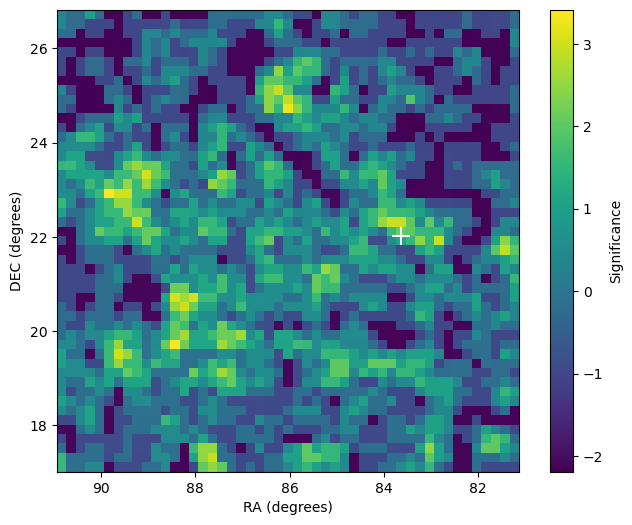

In [119]:
sig = calc_sigmap()

fig, ax = plt.subplots(figsize=(8, 6))

hist = ax.hist2d(sig.testPosX, sig.testPosY, weights=sig.significance, bins=[bins_RA, bins_DEC], cmap='viridis')

ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_xlabel('RA (degrees)')
ax.set_ylabel('DEC (degrees)')

cbar = fig.colorbar(hist[3], ax=ax, label='Significance')
# circ1 = Circle(on_region, radius, facecolor='None', edgecolor='magenta', lw=1)
# ax.add_patch(circ1)
ax.scatter(*on_region,marker='+',color='white',s=150)

# plt.savefig('/home/nkorzoun/Downloads/sigmap.png',dpi=300)

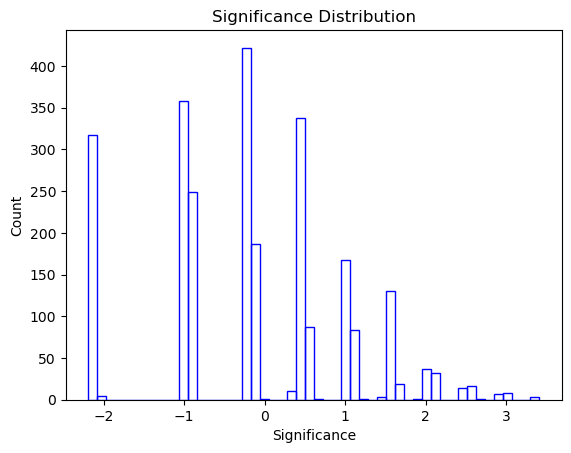

In [124]:
plt.hist(sig.significance, bins=50, edgecolor='blue',fill=None)
plt.xlabel('Significance')
plt.ylabel('Count')
# plt.yscale('log')
plt.title('Significance Distribution')
plt.show()

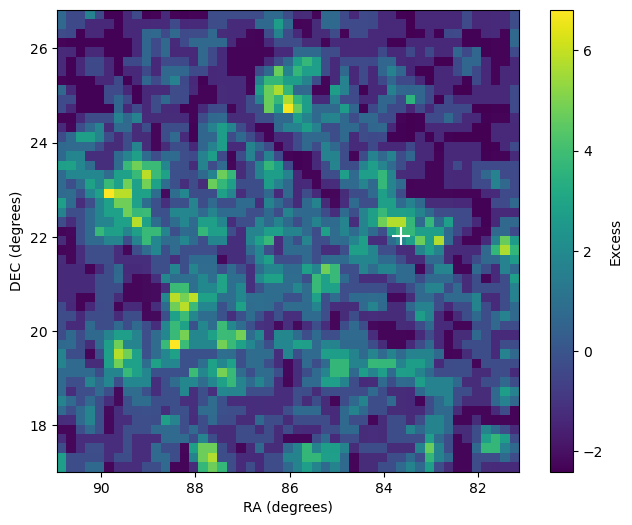

In [121]:
# excess map
excess=sig.on-sig.alpha*sig.off
fig, ax = plt.subplots(figsize=(8, 6))

hist = ax.hist2d(sig.testPosX, sig.testPosY,weights=excess, bins=[bins_RA, bins_DEC],cmap='viridis')

ax.invert_xaxis()
ax.set_aspect('equal')
ax.set_xlabel('RA (degrees)')
ax.set_ylabel('DEC (degrees)')

cbar = fig.colorbar(hist[3], ax=ax, label='Excess')
ax.scatter(*on_region, marker='+', color='white', s=150);

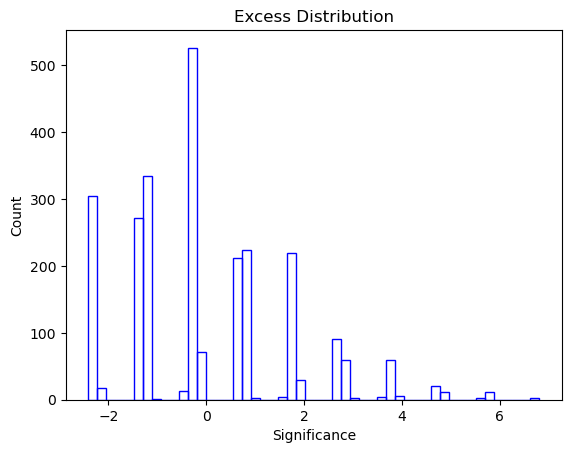

In [122]:
plt.hist(excess, bins=50, edgecolor='blue',fill=None)
plt.xlabel('Significance')
plt.ylabel('Count')
plt.title('Excess Distribution')
plt.show()

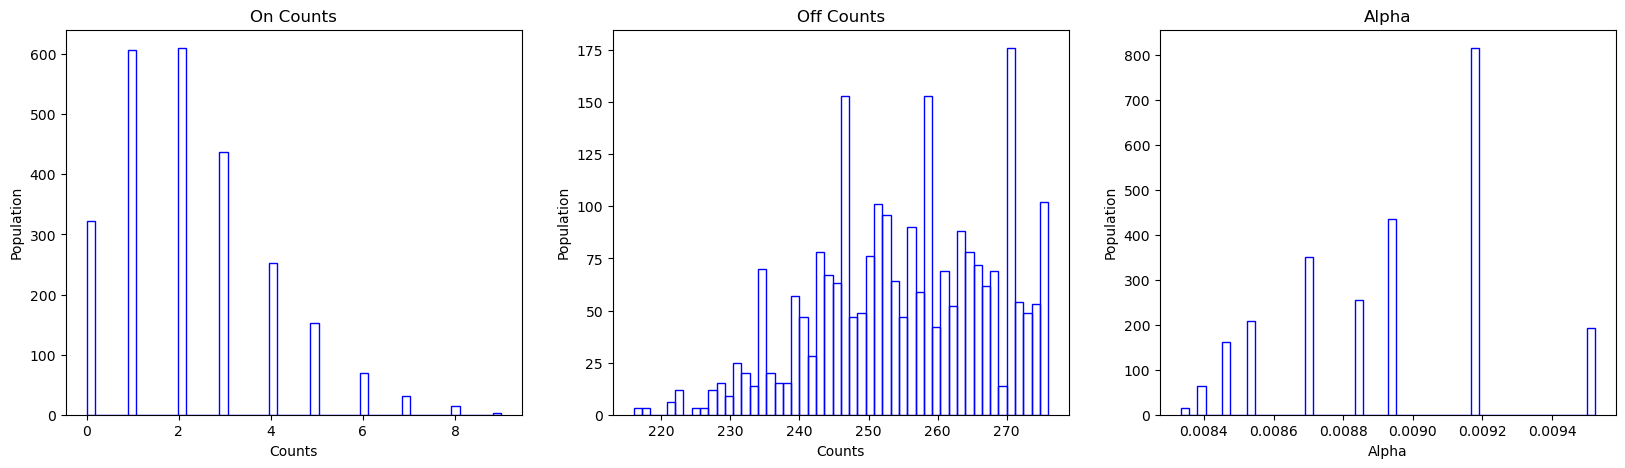

In [123]:
# other distributions
fig, axs = plt.subplots(1,3,figsize=(20, 5))
axs[0].hist(sig.on, bins=50, edgecolor='blue',fill=None)
axs[0].set_title('On Counts')
axs[0].set_xlabel('Counts')
axs[1].hist(sig.off, bins=50, edgecolor='blue',fill=None)
axs[1].set_title('Off Counts')
axs[1].set_xlabel('Counts')
axs[2].hist(sig.alpha, bins=50, edgecolor='blue',fill=None)
axs[2].set_title('Alpha')
axs[2].set_xlabel('Alpha')


for ax in axs:
    ax.set_ylabel('Population')

plt.show()